In [1]:
import pandas as pd
import numpy as np
import json
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import pprint
from os import listdir
from os.path import isfile, join
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import seaborn as sns


In [2]:
# Load Data 
tweets = pd.read_csv("tweets.csv", index_col=0)
print(tweets.shape)
tweets.head(5)

(2865, 19)


,index,text,created_at,user_id,user_name,reply_count,favorite_count,quote_count,retweet_count,hashtags,mentions,in_reply_to_user_id,user_created_at,user_followers_count,user_following_count,user_friends_count,user_listed_count,user_favourites_count,user_description
0,1420408706907394055,⠀@DeniseStefanie is “All In” to support Race f...,Wed Jul 28 15:40:00 +0000 2021,978265108563529728,RaceForRP,0,6,1,0,"allinforRP, RaceforRP, RelapsingPolychondritis...","DeniseStefanie, MusicCityGP, GoTransAm",NaN,Mon Mar 26 13:39:11 +0000 2018,2871,NaN,1450,8,4765,The Race for RP drives awareness and accelerat...
1,1420096159100571657,@ccfernandez Hi Charlene! I'm from Mexico and ...,Tue Jul 27 18:58:03 +0000 2021,1253109780421509123,Frijol En El Mundo,1,5,0,0,"RareDisease, RelapsingPolychondritis, chronicD...",ccfernandez,9.897224e+17,Wed Apr 22 23:54:07 +0000 2020,43,NaN,280,0,843,Just a human being trying to do my best
2,1420065257553289224,RT @RaceForRP: We’re excited that @DeniseStefa...,Tue Jul 27 16:55:15 +0000 2021,2438221916,Flewitt Racing,0,0,0,0,NaN,"RaceForRP, DeniseStefanie, MusicCityGP",NaN,Fri Apr 11 09:20:00 +0000 2014,1493,NaN,220,21,25972,Pure McLaren GT Series Champion 2018 & 2019 🏆 ...
3,1420051255502721027,RT @RaceForRP: We’re excited that @DeniseStefa...,Tue Jul 27 15:59:37 +0000 2021,475918341,The Trans Am Series,0,0,0,0,NaN,"RaceForRP, DeniseStefanie, MusicCityGP",NaN,Fri Jan 27 15:41:50 +0000 2012,6987,NaN,415,93,5774,The Official Trans Am Series Presented By Pire...
4,1420036578840354825,We’re excited that @DeniseStefanie will attend...,Tue Jul 27 15:01:18 +0000 2021,978265108563529728,RaceForRP,0,9,1,3,"allinforRP, RaceforRP, RelapsingPolychondritis","DeniseStefanie, MusicCityGP, GoTransAm",NaN,Mon Mar 26 13:39:11 +0000 2018,2871,NaN,1450,8,4765,The Race for RP drives awareness and accelerat...


### Preprocessing

In [3]:
# Tokenization, Stemming, Lemmatization

stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    # https://www.nltk.org/_modules/nltk/stem/wordnet.html
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(row):
    result=[]
    text = row["text"]
    text = re.sub(r"http[s]?\:[\w\.\/\-]+", "", text)
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

tweets["processed_text"] = tweets.apply(preprocess, axis=1)
tweets.head(5)


,index,text,created_at,user_id,user_name,reply_count,favorite_count,quote_count,retweet_count,hashtags,mentions,in_reply_to_user_id,user_created_at,user_followers_count,user_following_count,user_friends_count,user_listed_count,user_favourites_count,user_description,processed_text
0,1420408706907394055,⠀@DeniseStefanie is “All In” to support Race f...,Wed Jul 28 15:40:00 +0000 2021,978265108563529728,RaceForRP,0,6,1,0,"allinforRP, RaceforRP, RelapsingPolychondritis...","DeniseStefanie, MusicCityGP, GoTransAm",NaN,Mon Mar 26 13:39:11 +0000 2018,2871,NaN,1450,8,4765,The Race for RP drives awareness and accelerat...,"[denisestefani, support, race, musiccitygp, na..."
1,1420096159100571657,@ccfernandez Hi Charlene! I'm from Mexico and ...,Tue Jul 27 18:58:03 +0000 2021,1253109780421509123,Frijol En El Mundo,1,5,0,0,"RareDisease, RelapsingPolychondritis, chronicD...",ccfernandez,9.897224e+17,Wed Apr 22 23:54:07 +0000 2020,43,NaN,280,0,843,Just a human being trying to do my best,"[ccfernandez, charlen, mexico, rarediseas, cas..."
2,1420065257553289224,RT @RaceForRP: We’re excited that @DeniseStefa...,Tue Jul 27 16:55:15 +0000 2021,2438221916,Flewitt Racing,0,0,0,0,NaN,"RaceForRP, DeniseStefanie, MusicCityGP",NaN,Fri Apr 11 09:20:00 +0000 2014,1493,NaN,220,21,25972,Pure McLaren GT Series Champion 2018 & 2019 🏆 ...,"[raceforrp, excit, denisestefani, attend, musi..."
3,1420051255502721027,RT @RaceForRP: We’re excited that @DeniseStefa...,Tue Jul 27 15:59:37 +0000 2021,475918341,The Trans Am Series,0,0,0,0,NaN,"RaceForRP, DeniseStefanie, MusicCityGP",NaN,Fri Jan 27 15:41:50 +0000 2012,6987,NaN,415,93,5774,The Official Trans Am Series Presented By Pire...,"[raceforrp, excit, denisestefani, attend, musi..."
4,1420036578840354825,We’re excited that @DeniseStefanie will attend...,Tue Jul 27 15:01:18 +0000 2021,978265108563529728,RaceForRP,0,9,1,3,"allinforRP, RaceforRP, RelapsingPolychondritis","DeniseStefanie, MusicCityGP, GoTransAm",NaN,Mon Mar 26 13:39:11 +0000 2018,2871,NaN,1450,8,4765,The Race for RP drives awareness and accelerat...,"[excit, denisestefani, attend, musiccitygp, na..."


### Exploratory Data Analysis

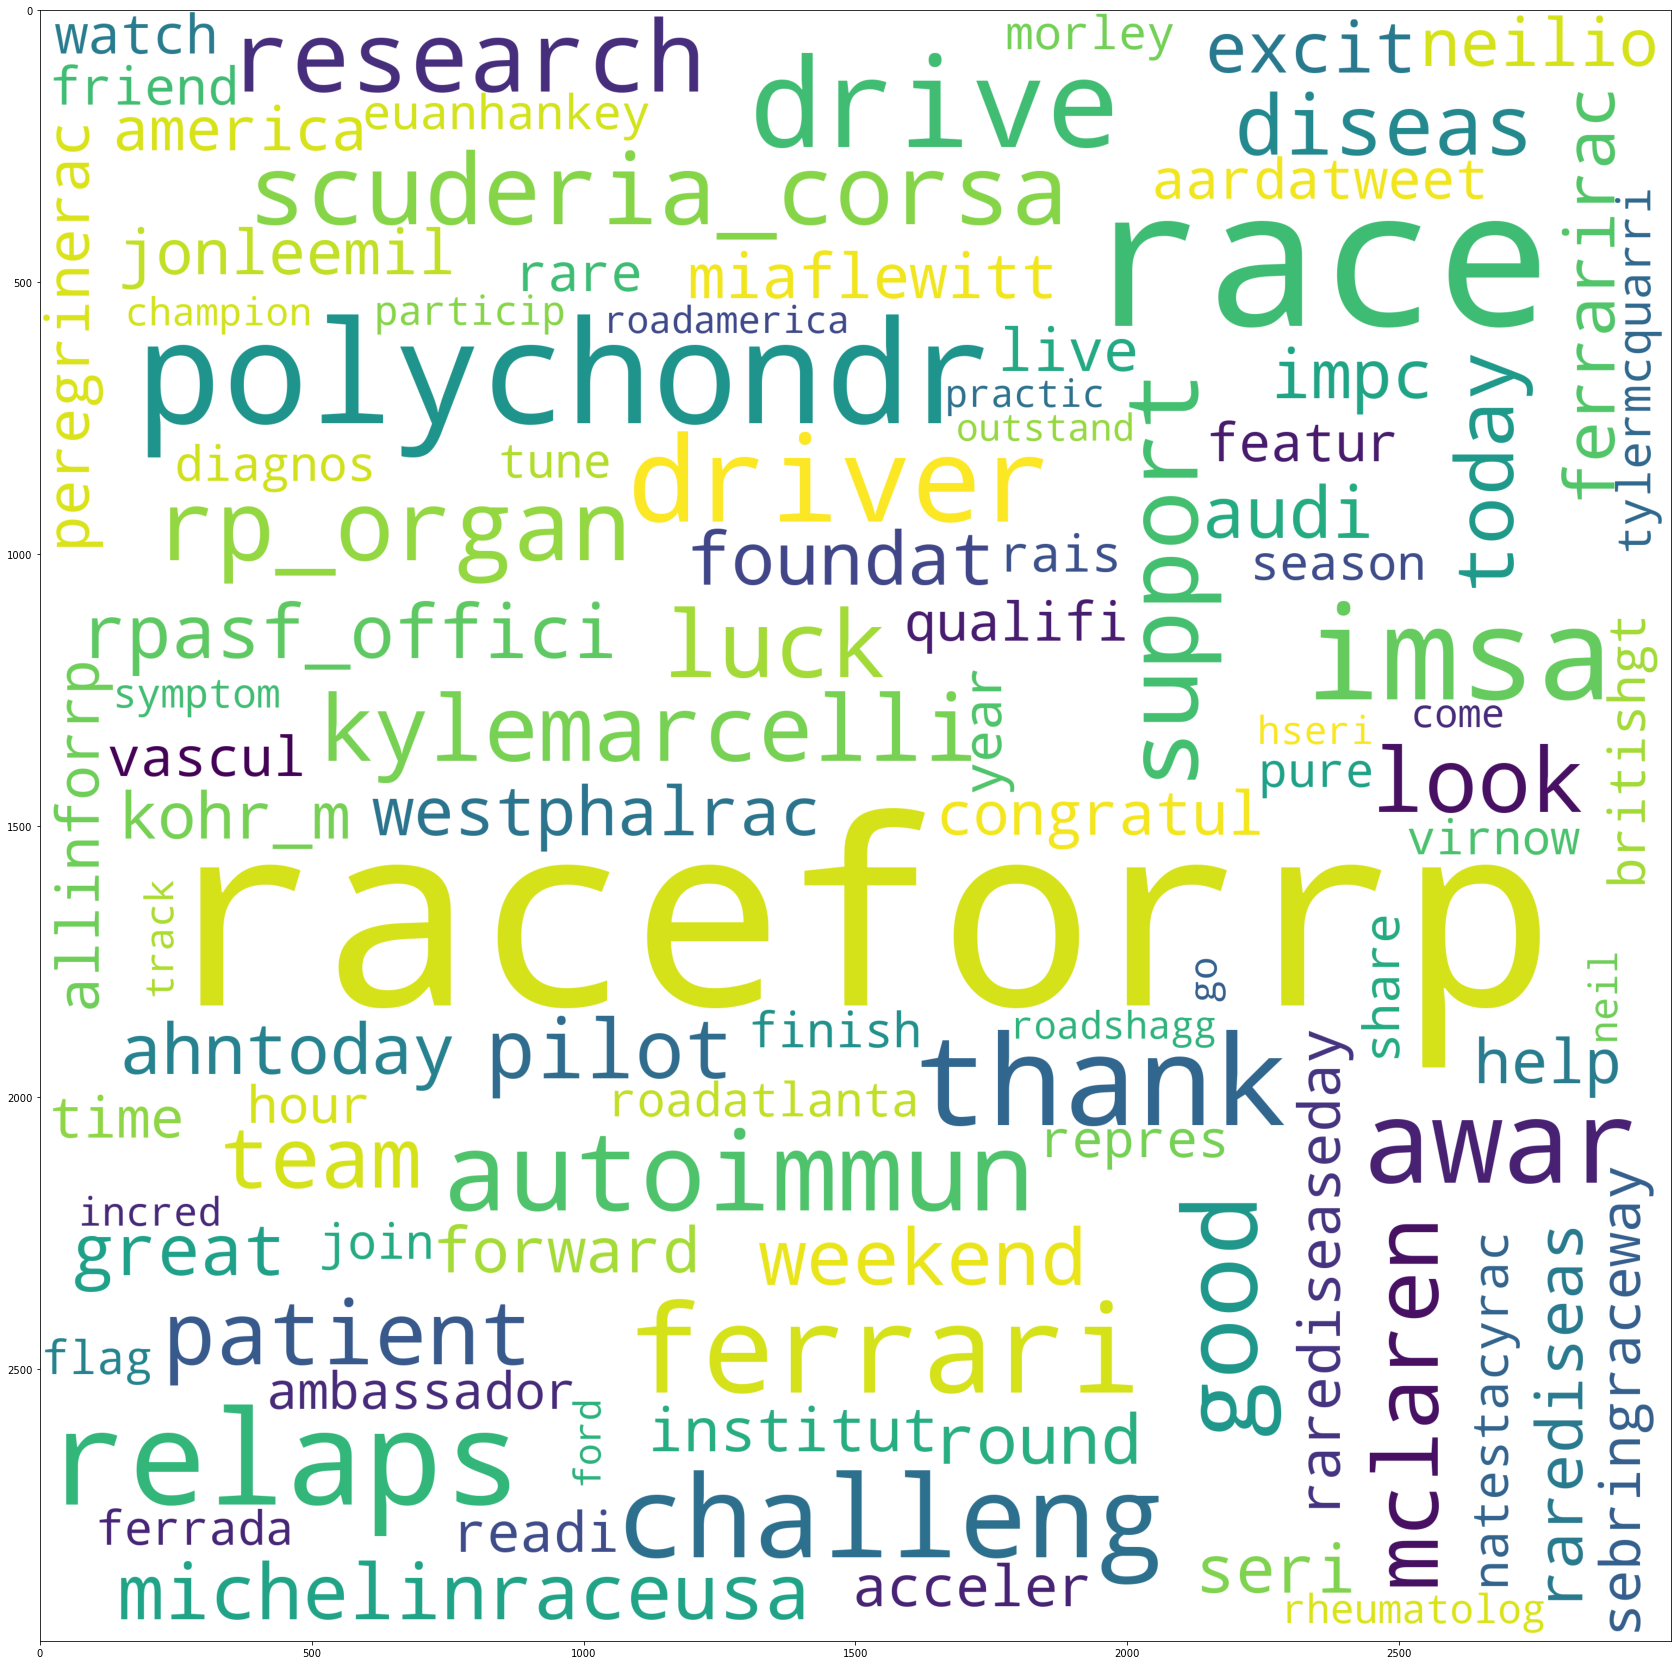

In [4]:
# token frequencies 

count_dict = Counter()
for index, row in tweets.iterrows(): 
    tokenized_list = row["processed_text"]
    count_dict.update(tokenized_list)
    
# generate word cloud
plt.figure(figsize=(30,30))
wc = WordCloud(background_color="white",
               width=3000,
               height=3000,
               max_words=100,
               relative_scaling=0.5).generate_from_frequencies(count_dict)

plt.imshow(wc)

<AxesSubplot:title={'center':'Top 10 words by Frequencies'}, xlabel='token'>

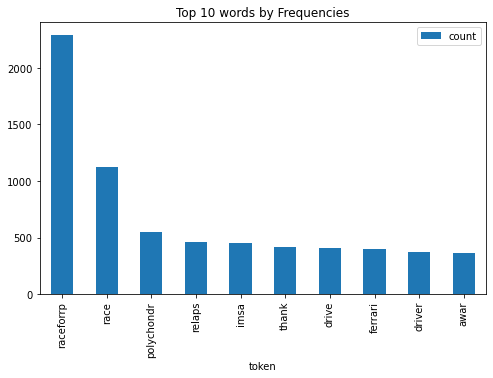

In [5]:
count_df = pd.DataFrame.from_dict(count_dict, orient="index", columns=["count"])
count_df = count_df.sort_values(by="count", axis=0, ascending=False)
count_df = count_df.reset_index().rename({"index": "token"}, axis=1)
count_df.head(10).plot(x="token", y="count", kind="bar", figsize=(8, 5), title="Top 10 words by Frequencies")


<AxesSubplot:title={'center':'Top 7 Tokens by Frequencies'}, xlabel='token'>

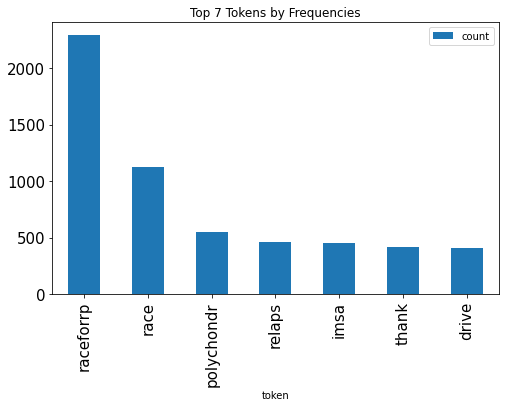

In [6]:
count_df.head(7).plot(x="token", y="count", kind="bar", figsize=(8, 5), title="Top 7 Tokens by Frequencies", fontsize=15)


In [7]:
distribution_df = tweets[["text", "processed_text"]]

def get_len_tweet(row): 
    return len(row["text"])

def get_len_tokens(row): 
    return len(row["processed_text"])

distribution_df["Tweet Length"] = distribution_df.apply(get_len_tweet, axis=1)
distribution_df["Number of Tokens After Processing"] = distribution_df.apply(get_len_tokens, axis=1)
distribution_df.head(2)

<ipython-input-7-e31e27a6b4eb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distribution_df["Tweet Length"] = distribution_df.apply(get_len_tweet, axis=1)
<ipython-input-7-e31e27a6b4eb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distribution_df["Number of Tokens After Processing"] = distribution_df.apply(get_len_tokens, axis=1)


,text,processed_text,Tweet Length,Number of Tokens After Processing
0,⠀@DeniseStefanie is “All In” to support Race f...,"[denisestefani, support, race, musiccitygp, na...",299,20
1,@ccfernandez Hi Charlene! I'm from Mexico and ...,"[ccfernandez, charlen, mexico, rarediseas, cas...",195,9


In [8]:
distribution_df.rename({"Tweet Length": "By Character"}, axis=1)

,text,processed_text,By Character,Number of Tokens After Processing
0,⠀@DeniseStefanie is “All In” to support Race f...,"[denisestefani, support, race, musiccitygp, na...",299,20
1,@ccfernandez Hi Charlene! I'm from Mexico and ...,"[ccfernandez, charlen, mexico, rarediseas, cas...",195,9
2,RT @RaceForRP: We’re excited that @DeniseStefa...,"[raceforrp, excit, denisestefani, attend, musi...",140,9
3,RT @RaceForRP: We’re excited that @DeniseStefa...,"[raceforrp, excit, denisestefani, attend, musi...",140,9
4,We’re excited that @DeniseStefanie will attend...,"[excit, denisestefani, attend, musiccitygp, na...",298,17
...,...,...,...,...
257,5 Symptoms Of Relapsing Polychondritis\nhttps:...,"[symptom, relaps, polychondr, symptom, polycho...",137,5
258,RT @Women_Bicycling: #RP #RaceforRP #LagunaSec...,"[women_bicycl, raceforrp, lagunaseca, watchvid...",140,7
259,#RP #RaceforRP #LagunaSeca #RelapsingPolychond...,"[raceforrp, lagunaseca, watchvideo, race, lagu...",138,6
260,RT @JenniferNaida: #RareDiseaseDay #Vasculiti...,"[jennifernaida, rarediseaseday, vascul, bless,...",140,5


array([[<AxesSubplot:title={'center':'By Character'}>]], dtype=object)

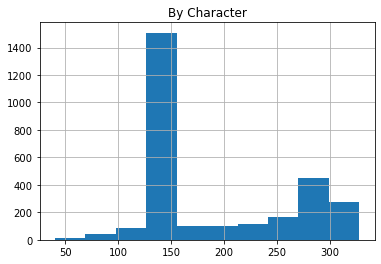

In [9]:
distribution_df.rename({"Tweet Length": "By Character"}, axis=1)[["By Character"]].hist(bins=10)

array([[<AxesSubplot:title={'center':'By Tokens'}>]], dtype=object)

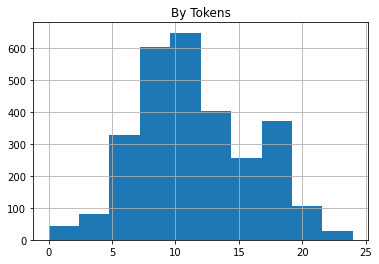

In [10]:
distribution_df.rename({"Number of Tokens After Processing": "By Tokens"}, axis=1)[["By Tokens"]].hist(bins=10)


In [115]:
def get_num_hashtags(row): 
    num_hashtags = 0
    hashtags = row["hashtags"]
    if type(hashtags) == str:
        hashtags_list = hashtags.split()
        num_hashtags = len(hashtags_list)
    return num_hashtags

def get_num_mentions(row): 
    num_mentions = 0
    mentions = row["mentions"]
    if type(mentions) == str: 
        mentions_list = mentions.split()
        num_mentions = len(mentions_list)
    return num_mentions

hashtags_mentions_df = tweets[["hashtags", "mentions"]]
hashtags_mentions_df["Number of Hashtags"] = hashtags_mentions_df.apply(get_num_hashtags, axis=1)
hashtags_mentions_df["Number of Mentions"] = hashtags_mentions_df.apply(get_num_mentions, axis=1)
hashtags_mentions_df.head(4)

<ipython-input-115-c05a0cf06ac8>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hashtags_mentions_df["Number of Hashtags"] = hashtags_mentions_df.apply(get_num_hashtags, axis=1)
<ipython-input-115-c05a0cf06ac8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hashtags_mentions_df["Number of Mentions"] = hashtags_mentions_df.apply(get_num_mentions, axis=1)


,hashtags,mentions,Number of Hashtags,Number of Mentions
0,"allinforRP, RaceforRP, RelapsingPolychondritis...","DeniseStefanie, MusicCityGP, GoTransAm",5,3
1,"RareDisease, RelapsingPolychondritis, chronicD...",ccfernandez,3,1
2,NaN,"RaceForRP, DeniseStefanie, MusicCityGP",0,3
3,NaN,"RaceForRP, DeniseStefanie, MusicCityGP",0,3


array([[<AxesSubplot:title={'center':'Number of Hashtags'}>]],
      dtype=object)

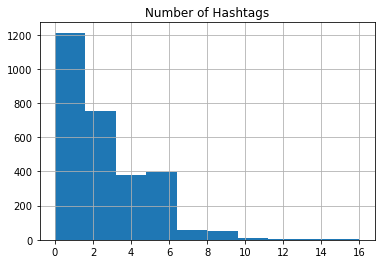

In [116]:
hashtags_mentions_df[["Number of Hashtags"]].hist(bins=10)

array([[<AxesSubplot:title={'center':'Number of Mentions'}>]],
      dtype=object)

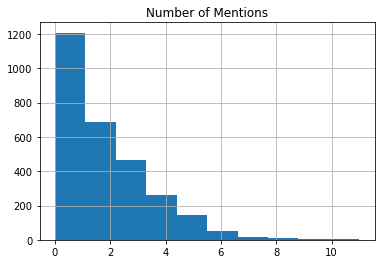

In [117]:
hashtags_mentions_df[["Number of Mentions"]].hist(bins=10)

In [121]:
tweets.columns

Index(['index', 'text', 'created_at', 'user_id', 'user_name', 'reply_count',
       'favorite_count', 'quote_count', 'retweet_count', 'hashtags',
       'mentions', 'in_reply_to_user_id', 'user_created_at',
       'user_followers_count', 'user_following_count', 'user_friends_count',
       'user_listed_count', 'user_favourites_count', 'user_description',
       'processed_text'],
      dtype='object')

In [137]:
# Top 20 Users by Number of Tweets
users_df = tweets[["index", "user_id", "user_name", "user_followers_count", 
                   "user_following_count", "user_friends_count", "user_listed_count", "user_favourites_count"]]

# top 20 users that have posted most number of tweets
users_top_20 = users_df[["user_name", "index"]].groupby(["user_name"]).count().rename({"index": "num_tweets"}, axis=1).sort_values(by="num_tweets", ascending=False).head(20)
users_top_20



,num_tweets
user_name,
RaceForRP,1060
Relapsing Polychondritis Foundation,264
R Polychondritis,172
Flewitt Racing,54
linda vanthournout,42
Policondrite Amigos,36
Autoimmune Association,33
Carole Cooper,28
Peregrine Racing,24


<AxesSubplot:title={'center':'Top 20 Twitter Accounts that have tweeted the most'}, xlabel='user_name'>

/Users/jessjkim/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127895 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jessjkim/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127895 missing from current font.
  font.set_text(s, 0, flags=flags)


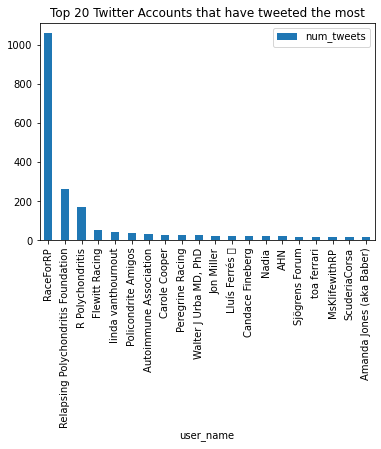

In [151]:
# Plot Bar Chart for the Top 20 users by number of tweets
users_top_20.plot(use_index=True, 
                  y="num_tweets", 
                  kind="bar",
                  title="Top 20 Twitter Accounts that have tweeted the most")



<AxesSubplot:title={'center':'Top 20 Most Followed Twitter Account'}, xlabel='user_name'>

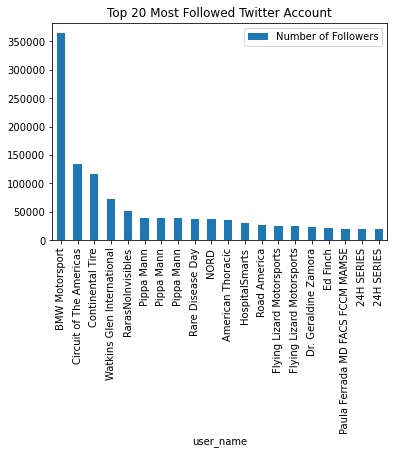

In [152]:
followers_count = users_df[["user_name", "user_followers_count"]].rename({"user_followers_count": "Number of Followers"}, axis=1)
followers_count = followers_count.sort_values(by="Number of Followers", ascending=False)

# followers_count.plot()
followers_count[:20].plot(x="user_name", y="Number of Followers", 
                          kind="bar", title="Top 20 Most Followed Twitter Account")


### Additional EDA

#### M3Inference

We will use M3Inference to infer user type whether it is an organization or individual.

[M3Inference](https://github.com/euagendas/m3inference) is a deep learning system for demographic inference (such as gender, age, and individual/organization). It is based on WebConf (WWW) 2019 paper [Demographic Inference and Representative Population Estimates from Multilingual Social Media Data](https://dl.acm.org/doi/10.1145/3308558.3313684) by Wang et al.

In [468]:
# to retrieve more users data through Twitter API 
users_df2 = users_df[["user_id", "user_name", "user_followers_count", 
                      "user_following_count", "user_friends_count", 
                      "user_listed_count", "user_favourites_count"]]
users_only = users_df2.drop_duplicates(subset="user_id")
users_only.to_csv("users_data.csv")


Before running the next cell, first run **get_users_data.py** in order to get extensive user objects from Twitter, which is needed as an input for M3inference. 

In [505]:
def process_json_user_files(filepath, filename): 
    filepath = "{}/{}".format(filepath, filename)
    with open(filepath) as f:
        user_list = json.load(f)
    return user_list

# import files for users data 
output_files_path = "more_users_data"
users_json_files = [f for f in listdir(output_files_path) if (isfile(join(output_files_path, f))) & ("json" in f)]
# print(len(users_json_files))

list_of_users_json = []
for jsonfile in users_json_files:
    users_bunch = process_json_user_files(output_files_path, jsonfile)
    list_of_users_json.extend(users_bunch)

with open('m3inference/users_data.jsonl', 'w') as outfile:
    for entry in list_of_users_json:
        json.dump(entry, outfile)
        outfile.write('\n')

In [506]:
from m3inference import M3Twitter
import pprint

m3twitter = M3Twitter() 
m3twitter.transform_jsonl(input_file="m3inference/users_data.jsonl", 
                          output_file="m3inference/m3_input1.jsonl")

m3_inference_output = m3twitter.infer("m3inference/m3_input1.jsonl")
pprint.pprint(m3twitter.infer("m3inference/m3_input1.jsonl")) 


12/03/2021 20:48:49 - INFO - m3inference.m3inference -   Version 1.1.5
12/03/2021 20:48:49 - INFO - m3inference.m3inference -   Running on cpu.
12/03/2021 20:48:49 - INFO - m3inference.m3inference -   Will use full M3 model.
12/03/2021 20:48:49 - INFO - m3inference.m3inference -   Model full_model exists at /Users/jessjkim/m3/models/full_model.mdl.
12/03/2021 20:48:49 - INFO - m3inference.utils -   Checking MD5 for model full_model at /Users/jessjkim/m3/models/full_model.mdl
12/03/2021 20:48:49 - INFO - m3inference.utils -   MD5s match.
12/03/2021 20:48:50 - INFO - m3inference.m3inference -   Loaded pretrained weight at /Users/jessjkim/m3/models/full_model.mdl
12/03/2021 20:50:01 - INFO - m3inference.dataset -   443 data entries loaded.
Predicting...: 100%|██████████| 28/28 [02:12<00:00,  4.75s/it]
12/03/2021 20:52:13 - INFO - m3inference.dataset -   443 data entries loaded.
Predicting...: 100%|██████████| 28/28 [02:10<00:00,  4.65s/it]


OrderedDict([('3166193421',
              {'age': {'19-29': 0.2245,
                       '30-39': 0.4255,
                       '<=18': 0.0711,
                       '>=40': 0.279},
               'gender': {'female': 0.188, 'male': 0.812},
               'org': {'is-org': 0.9197, 'non-org': 0.0803}}),
             ('3249492988',
              {'age': {'19-29': 0.4769,
                       '30-39': 0.3227,
                       '<=18': 0.1439,
                       '>=40': 0.0565},
               'gender': {'female': 0.9902, 'male': 0.0098},
               'org': {'is-org': 0.6295, 'non-org': 0.3705}}),
             ('1213254252174295041',
              {'age': {'19-29': 0.2225,
                       '30-39': 0.6006,
                       '<=18': 0.0357,
                       '>=40': 0.1411},
               'gender': {'female': 0.0001, 'male': 0.9999},
               'org': {'is-org': 0.0, 'non-org': 1.0}}),
             ('2493100691',
              {'age': {'19-29': 0.0595,

              {'age': {'19-29': 0.0015,
                       '30-39': 0.0004,
                       '<=18': 0.0004,
                       '>=40': 0.9977},
               'gender': {'female': 0.3717, 'male': 0.6283},
               'org': {'is-org': 0.6965, 'non-org': 0.3035}}),
             ('1161763689629999110',
              {'age': {'19-29': 0.0005,
                       '30-39': 0.0278,
                       '<=18': 0.0005,
                       '>=40': 0.9712},
               'gender': {'female': 0.9998, 'male': 0.0002},
               'org': {'is-org': 0.0001, 'non-org': 0.9999}}),
             ('346151348',
              {'age': {'19-29': 0.0007,
                       '30-39': 0.0158,
                       '<=18': 0.0005,
                       '>=40': 0.9831},
               'gender': {'female': 0.8387, 'male': 0.1613},
               'org': {'is-org': 0.317, 'non-org': 0.683}}),
             ('1325233229612376068',
              {'age': {'19-29': 0.649,
             

                       '>=40': 0.0051},
               'gender': {'female': 0.0, 'male': 1.0},
               'org': {'is-org': 0.0, 'non-org': 1.0}}),
             ('1263426822',
              {'age': {'19-29': 0.0, '30-39': 0.0, '<=18': 0.0, '>=40': 0.9999},
               'gender': {'female': 0.9865, 'male': 0.0135},
               'org': {'is-org': 0.5057, 'non-org': 0.4943}}),
             ('310055182',
              {'age': {'19-29': 0.0026,
                       '30-39': 0.035,
                       '<=18': 0.0006,
                       '>=40': 0.9618},
               'gender': {'female': 0.9995, 'male': 0.0005},
               'org': {'is-org': 0.0006, 'non-org': 0.9994}}),
             ('986385477849796608',
              {'age': {'19-29': 0.5626,
                       '30-39': 0.2854,
                       '<=18': 0.1207,
                       '>=40': 0.0313},
               'gender': {'female': 0.0117, 'male': 0.9883},
               'org': {'is-org': 0.0003, 'non-org'

                       '>=40': 0.9985},
               'gender': {'female': 0.9554, 'male': 0.0446},
               'org': {'is-org': 0.014, 'non-org': 0.986}}),
             ('27557675',
              {'age': {'19-29': 0.0001,
                       '30-39': 0.0001,
                       '<=18': 0.0001,
                       '>=40': 0.9997},
               'gender': {'female': 0.0003, 'male': 0.9997},
               'org': {'is-org': 0.0008, 'non-org': 0.9992}}),
             ('394115279',
              {'age': {'19-29': 0.2795,
                       '30-39': 0.4571,
                       '<=18': 0.0798,
                       '>=40': 0.1836},
               'gender': {'female': 0.0021, 'male': 0.9979},
               'org': {'is-org': 0.2674, 'non-org': 0.7326}}),
             ('1069694643971989510',
              {'age': {'19-29': 0.6625,
                       '30-39': 0.037,
                       '<=18': 0.288,
                       '>=40': 0.0125},
               'gender': 

                       '30-39': 0.2919,
                       '<=18': 0.0007,
                       '>=40': 0.6999},
               'gender': {'female': 0.0001, 'male': 0.9999},
               'org': {'is-org': 0.0001, 'non-org': 0.9999}}),
             ('1253385149829517313',
              {'age': {'19-29': 0.7262,
                       '30-39': 0.0229,
                       '<=18': 0.2394,
                       '>=40': 0.0115},
               'gender': {'female': 0.0441, 'male': 0.9559},
               'org': {'is-org': 0.5651, 'non-org': 0.4349}}),
             ('1282426169162440708',
              {'age': {'19-29': 0.0148,
                       '30-39': 0.0054,
                       '<=18': 0.0689,
                       '>=40': 0.911},
               'gender': {'female': 0.0047, 'male': 0.9953},
               'org': {'is-org': 0.8318, 'non-org': 0.1682}}),
             ('20171071',
              {'age': {'19-29': 0.5397,
                       '30-39': 0.123,
             

In [579]:
gender_dictionary = {}
org_dictionary = {}
age_dictionary = {}

for userid, values in m3_inference_output.items(): 
    gender_dict = values["gender"]
    age_dict = values["age"]
    org_dict = values["org"]
    gender_dictionary[userid] = gender_dict
    org_dictionary[userid] = org_dict
    age_dictionary[userid] = age_dict

gender_m3_inference_df = pd.DataFrame.from_dict(gender_dictionary, orient="index").reset_index().rename({"index": "user_id"}, axis=1)
gender_m3_inference_df = gender_m3_inference_df.astype({"user_id": np.int64})
gender_m3_inference_df = gender_m3_inference_df.set_index("user_id")

org_m3_inference_df = pd.DataFrame.from_dict(org_dictionary, orient="index").reset_index().rename({"index": "user_id"}, axis=1)
org_m3_inference_df = org_m3_inference_df.astype({"user_id": np.int64})
org_m3_inference_df = org_m3_inference_df.set_index("user_id")

age_m3_inference_df = pd.DataFrame.from_dict(age_dictionary, orient="index").reset_index().rename({"index": "user_id"}, axis=1)
age_m3_inference_df = age_m3_inference_df.astype({"user_id": np.int64})
age_m3_inference_df = age_m3_inference_df.set_index("user_id")



In [585]:
# merge the m3inference outcome with the users data 
users_only2 = users_only.set_index("user_id")
users_only = pd.concat([users_only2, org_m3_inference_df, gender_m3_inference_df], axis=1)
users_only.head(4)

,user_name,user_followers_count,user_following_count,user_friends_count,user_listed_count,user_favourites_count,non-org,is-org,male,female
user_id,,,,,,,,,,
7819212,Donna Mattison,384,NaN,405,14,7483,0.9996,0.0004,0.0045,0.9955
13494642,ericlinuskaplan,5750,NaN,3799,112,9085,0.9988,0.0012,0.9928,0.0072
14363869,Kyle Marcelli,2451,NaN,744,82,4954,0.9988,0.0012,0.9998,0.0002
15055784,Lupus News,12552,NaN,147,181,6852,0.0834,0.9166,0.9473,0.0527


In [587]:
# get the number of user per user type using organization threshold of 0.5
org_threshold = 0.5
def get_organization(row): 
    output = "PERSON"
    if row["is-org"] > 0.5: 
        output = "ORG"
    
    return output
users_only["user_type"] = users_only.apply(get_organization, axis=1)
users_only.head(2)


,user_name,user_followers_count,user_following_count,user_friends_count,user_listed_count,user_favourites_count,non-org,is-org,male,female,user_type
user_id,,,,,,,,,,,
7819212,Donna Mattison,384,NaN,405,14,7483,0.9996,0.0004,0.0045,0.9955,PERSON
13494642,ericlinuskaplan,5750,NaN,3799,112,9085,0.9988,0.0012,0.9928,0.0072,PERSON


In [591]:
users_only[["user_type", "user_name"]].groupby("user_type").count().rename({"user_name": "num_accounts"}, axis=1)


,num_accounts
user_type,
ORG,104
PERSON,339


In [601]:
# get the number of tweets per user type 
tweets2 = tweets.copy(deep=True)
tweets2 = tweets2[["index", "user_id"]]

def get_user_type(row): 
    user_id = row["user_id"]
    user_type = users_only["user_type"].loc[int(user_id)]
    return user_type

tweets2["user_type"] = tweets2.apply(get_user_type, axis=1)
tweets2[["index", "user_type"]].groupby("user_type").count().rename({"index": "num_tweets"}, axis=1)


,num_tweets
user_type,
ORG,1883
PERSON,982


In [679]:
982/(1883+982)

0.34275741710296687

In [677]:
users_only

,user_name,user_followers_count,user_following_count,user_friends_count,user_listed_count,user_favourites_count,non-org,is-org,male,female,user_type
user_id,,,,,,,,,,,
7819212,Donna Mattison,384,NaN,405,14,7483,0.9996,0.0004,0.0045,0.9955,PERSON
13494642,ericlinuskaplan,5750,NaN,3799,112,9085,0.9988,0.0012,0.9928,0.0072,PERSON
14363869,Kyle Marcelli,2451,NaN,744,82,4954,0.9988,0.0012,0.9998,0.0002,PERSON
15055784,Lupus News,12552,NaN,147,181,6852,0.0834,0.9166,0.9473,0.0527,ORG
15802519,Pamela @🏡,1053,NaN,239,85,244637,1.0000,0.0000,0.0072,0.9928,PERSON
...,...,...,...,...,...,...,...,...,...,...,...
1398731361599557634,MsKlifewithRP,46,NaN,162,0,931,0.9979,0.0021,0.0009,0.9991,PERSON
1401545891459129349,Deepak,0,NaN,6,0,5,1.0000,0.0000,0.9993,0.0007,PERSON
1402962373321707525,Dr Madhuri Nama,0,NaN,110,0,80,0.9739,0.0261,0.9688,0.0312,PERSON


In [848]:
def infer_gender(row): 
    if row["user_type"] == "PERSON": 
        if row["male"] > 0.5: 
            output = "MALE"
        elif row["female"] > 0.5: 
            output = "FEMALE"
        else: 
            output = "UNDECIDED"
    else: 
        output = "ORGANIZATION-UNDECIDED"
    
    return output

users_only["gender"] = users_only.apply(infer_gender, axis=1)

In [849]:
users_only[["gender", "user_name"]].groupby("gender").count().rename({"user_name": "count"}, axis=1)

,count
gender,
FEMALE,158
MALE,181
ORGANIZATION-UNDECIDED,104


In [850]:
# get the number of tweets per user type 
tweets3 = tweets.copy(deep=True)
tweets3 = tweets3[["index", "user_id"]]

def get_gender(row): 
    user_id = row["user_id"]
    user_type = users_only["gender"].loc[int(user_id)]
    return user_type

tweets3["gender"] = tweets3.apply(get_gender, axis=1)
tweets3[["index", "gender"]].groupby("gender").count().rename({"index": "num_tweets"}, axis=1)


,num_tweets
gender,
FEMALE,506
MALE,476
ORGANIZATION-UNDECIDED,1883


### Topic Modeling: Latent Dirichlet Allocation (LDA)

In [11]:
# prepare for LDA 
processed_tweets_list = list(tweets["processed_text"])   
dictionary = gensim.corpora.Dictionary(processed_tweets_list)

# https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html
# Filter out tokens that appear in
# less than no_below documents (absolute number) or
# more than no_above documents (fraction of total corpus size, not absolute number).
# after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).

dictionary.filter_extremes(no_below=1, no_above=0.7) # executes in-place

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_tweets_list]


In [12]:
# Look for the most optimal number of topics for LDA 
# some code from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

coherence_values = [] # Coherence values corresponding to the LDA model with respective number of topics
model_list = [] # List of LDA topic models
perplexity_list = [] # List of perplexity scores 

num_topics_list = list(range(2, 22, 2))

for num_topics in num_topics_list:
    model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, 
                                       id2word=dictionary, random_state=0)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=processed_tweets_list, 
                                    dictionary=dictionary, coherence='c_v')
    
    perplexity = model.log_perplexity(bow_corpus)
    perplexity_list.append(perplexity)
    coherence_values.append(coherencemodel.get_coherence())


### Evaluation

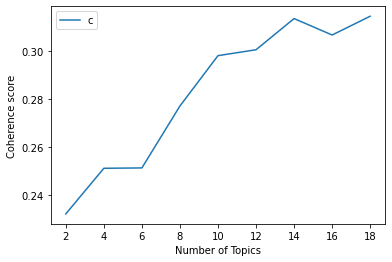

In [64]:
# Plot Graph for Coherence Scores vs Number of Topics 
x = num_topics_list
plt.plot(x[:-1], coherence_values[:-1])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


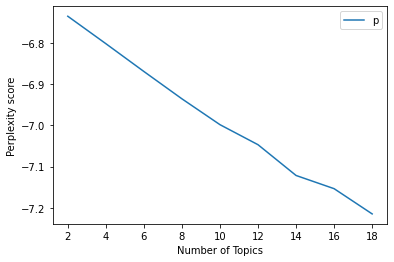

In [62]:
# Plot Graph for Perplexity Scores vs Number of Topics 
x = num_topics_list
plt.plot(x[:-1], perplexity_list[:-1])
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_list"), loc='best')
plt.show()


#### Jaccard Similarity 

In [16]:
# some code from 
# https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin

def jaccard_similarity(topic_1, topic_2):
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))               
    return float(len(intersection))/float(len(union))

num_words_shown = 22
topics_overlaps = {}

for idx in range(0, len(num_topics_list)-1): 
    jaccard_similarities = []
    current_topics = model_list[idx].show_topics(num_topics=idx, 
                                                 num_words=num_words_shown,
                                                 formatted=False)
    next_topics = model_list[idx+1].show_topics(num_topics=idx+1, 
                                                num_words=num_words_shown, 
                                                formatted=False)
    
    # list of lists where each sublist are words corresponding to topics 
    current_topics_only_words = [[word[0] for word in topic[1]] for topic in current_topics]
    next_topics_only_words = [[word[0] for word in topic[1]] for topic in next_topics]
    
    for idx_topic1, current_topic in enumerate(current_topics_only_words): 
        similarities = []
        for idx_topic2, next_topic in enumerate(next_topics_only_words):
            similarities.append(jaccard_similarity(current_topic, next_topic))
        jaccard_similarities.append(similarities)
        
    topics_overlaps[num_topics_list[idx]] = jaccard_similarities
    
# average the jaccard similiarities scores by each number of topics  
avg_similarities = [np.array(topics_overlaps[i]).mean() for i in num_topics_list[:-1]]
avg_similarities 


[0.6005291005291005,
 0.6133333333333333,
 0.5498741105637658,
 0.455362558588365,
 0.3271078431372549,
 0.4078554275244389,
 0.39151082987262614,
 0.3556367244353605,
 0.3457559034655842]

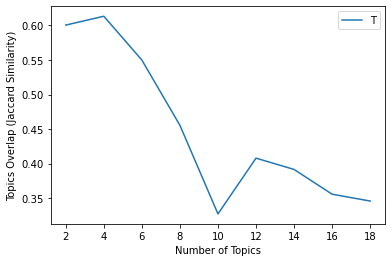

In [17]:
# Plot Graph for Topics Overlap by Jaccard Similarity vs Number of Topics 
x = num_topics_list[:-1]
plt.plot(x, avg_similarities)
plt.xlabel("Number of Topics")
plt.ylabel("Topics Overlap (Jaccard Similarity)")
plt.legend(("Topic Similarities"), loc='best')
plt.show()


In [18]:
# get the optimal number of topics based on coherence score and mean jaccard similarity
max_optimal_model_idx = np.argmax(np.array(coherence_values[:-1])-np.array(avg_similarities))
print("Optimal Number of Topics: {}".format(num_topics_list[max_optimal_model_idx]))

optimal_LDA_model = model_list[max_optimal_model_idx]


Optimal Number of Topics: 10


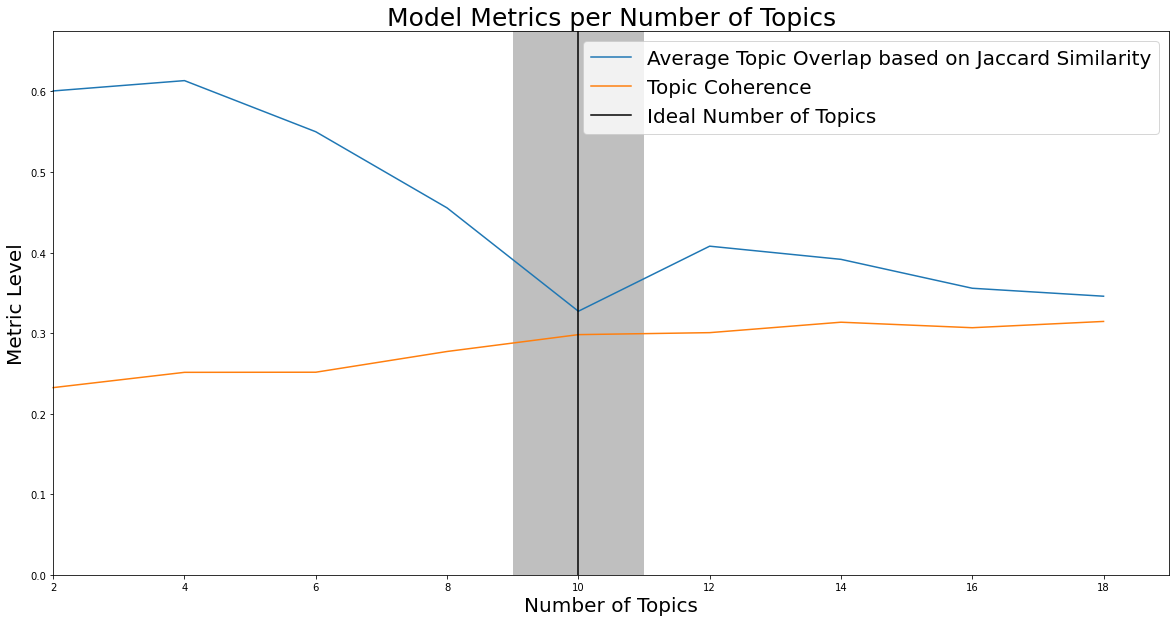

In [24]:
# https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin
ideal_topic_num = num_topics_list[max_optimal_model_idx]

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics_list[:-1], y=avg_similarities, label='Average Topic Overlap based on Jaccard Similarity', clip_on=False)
ax = sns.lineplot(x=num_topics_list[:-1], y=coherence_values[:-1], label='Topic Coherence', clip_on=False)

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num+1, alpha=0.5, facecolor='grey')

y_max = max(max(avg_similarities), max(coherence_values)) + (0.10 * max(max(avg_similarities), max(coherence_values)))
ax.set_ylim([0, y_max])
ax.set_xlim([2, num_topics_list[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   



In [69]:
topic_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [66]:
# plot topics and themes identified in the corpus 
num_plot_in_row = 5
num_rows = int(10/num_plot_in_row)

color_list1 = [value for key, value in mcolors.TABLEAU_COLORS.items()]
color_list2 = [value for key, value in mcolors.CSS4_COLORS.items()]
color_list = color_list1

fig, axes = plt.subplots(nrows=num_rows, 
                         ncols=num_plot_in_row, 
                         figsize=(70,40), 
                         dpi=400)

row_num_id = 0
col_num_id = 0
topic_list = list(range(num_topics_list[max_optimal_model_idx]))

for topic_idx in topic_list: # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    if (topic_idx % num_plot_in_row == 0) and (topic_idx > 0):
        row_num_id += 1
        col_num_id = 0
    
    topics_list = optimal_LDA_model.show_topic(topic_idx)
    word_list = [pair[0] for pair in topics_list]
    prob_list = [pair[1] for pair in topics_list]
    df_r = pd.DataFrame.from_dict({"term": word_list, "prob": prob_list}, 
                                  orient="columns").sort_values(by="prob", ascending=False)
    
    topic_title = "Topic {}".format(topic_idx)
    
    # https://stackoverflow.com/questions/29511645/pandas-plot-x-or-index-column-in-descending-order/29526163
    df_r = df_r[::-1]
    
    df_r.plot(ax=axes[row_num_id, col_num_id], 
              kind="barh", x="term", y="prob", title=topic_title,
              color=color_list[topic_idx], fontsize=15)
    # axes[0].title.set_size(40)
    axes[row_num_id, col_num_id].title.set_size(20)
    
    col_num_id += 1
    
# https://stackoverflow.com/questions/4325733/save-a-subplot-in-matplotlib



<AxesSubplot:title={'center':'Topic 9'}, ylabel='term'>

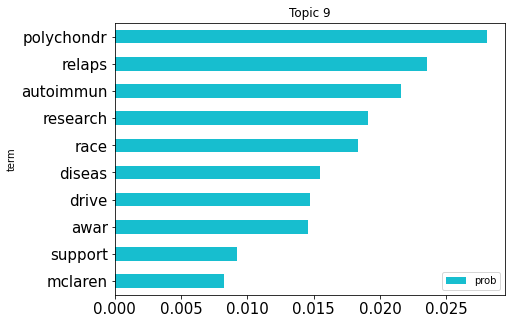

In [82]:
# plot each topic individually
topic_idx = 9

topics_list =optimal_LDA_model.show_topic(topic_idx)
word_list = [pair[0] for pair in topics_list]
prob_list = [pair[1] for pair in topics_list]
df_r = pd.DataFrame.from_dict({"term": word_list, "prob": prob_list}, 
                              orient="columns").sort_values(by="prob", ascending=False)
    
topic_title = "Topic {}".format(topic_idx)
    
    # https://stackoverflow.com/questions/29511645/pandas-plot-x-or-index-column-in-descending-order/29526163
df_r = df_r[::-1]
    
df_r.plot(kind="barh", x="term", y="prob", title=topic_title, figsize=(7,5),
          color=color_list[topic_idx], fontsize=15)
    

In [67]:
fig.savefig('lda_topics.png', pad_inches=0, transparent=True, edgecolor="black", facecolor="white")

In [33]:
# print all the topics 
for topic_idx in topic_list:
    output_list = optimal_LDA_model.show_topic(topic_idx)
    listwords = [tupl[0] for tupl in output_list]
    print("Topic {}:".format(topic_idx), listwords) 
    

Topic 0: ['race', 'polychondr', 'relaps', 'imsa', 'challeng', 'drive', 'driver', 'ferrari', 'good', 'thank']
Topic 1: ['race', 'good', 'luck', 'drive', 'autoimmun', 'patient', 'awar', 'rp_organ', 'weekend', 'imsa']
Topic 2: ['race', 'drive', 'thank', 'team', 'ferrari', 'weekend', 'kylemarcelli', 'autoimmun', 'awar', 'imsa']
Topic 3: ['thank', 'race', 'polychondr', 'mclaren', 'relaps', 'support', 'rp_organ', 'challeng', 'look', 'patient']
Topic 4: ['race', 'driver', 'polychondr', 'rp_organ', 'relaps', 'challeng', 'autoimmun', 'kylemarcelli', 'patient', 'imsa']
Topic 5: ['race', 'ferrari', 'challeng', 'imsa', 'thank', 'polychondr', 'awar', 'relaps', 'look', 'drive']
Topic 6: ['race', 'imsa', 'rarediseaseday', 'thank', 'mclaren', 'today', 'polychondr', 'autoimmun', 'miaflewitt', 'driver']
Topic 7: ['imsa', 'race', 'driver', 'challeng', 'impc', 'awar', 'michelinraceusa', 'scuderia_corsa', 'support', 'pilot']
Topic 8: ['race', 'awar', 'good', 'ferrari', 'polychondr', 'drive', 'relaps', 'scu

In [83]:
tweets4 = tweets.copy(deep=True)
tweets4 = tweets4[["index", "text", "processed_text"]].set_index("index")

def get_max_topic(element): 
    output = element[0][0]
    
    if len(element) > 1: 
        output = sorted(element, key=lambda x: x[0], reverse=True)[0][0]
    return output

topicfortext_list = [get_max_topic(element) for element in optimal_LDA_model[bow_corpus]]

tweets4["Topic # according to LDA"] = topicfortext_list
tweets4.head(3)


,text,processed_text,Topic # according to LDA
index,,,
1420408706907394055,⠀@DeniseStefanie is “All In” to support Race f...,"[denisestefani, support, race, musiccitygp, na...",0
1420096159100571657,@ccfernandez Hi Charlene! I'm from Mexico and ...,"[ccfernandez, charlen, mexico, rarediseas, cas...",9
1420065257553289224,RT @RaceForRP: We’re excited that @DeniseStefa...,"[raceforrp, excit, denisestefani, attend, musi...",9


In [43]:
v = tweets4["text"].str.contains("Today I have a home-infusion of a TNF-inhibitor for")
tweets4.loc[v[v == True].index[0]]


text                        RT @CPalmerlee: Today I have a home-infusion o...
processed_text                     [cpalmerle, today, home, infus, inhibitor]
Topic # according to LDA                                                    9
Name: 1176875451458957312, dtype: object

In [84]:
for topic_idx in topic_list:
    tweets4[tweets4["Topic # according to LDA"] == topic_idx]["text"].to_csv("topics/topic{}.csv".format(topic_idx))


In [724]:
tweets4[tweets4["Topic # according to LDA"] == 9]["text"].to_csv("topic.csv")

In [720]:
tweets4[tweets4["Topic # according to LDA"] == 17]["text"].loc[938485755051159554]

"@NorthShoreWeb Indeed! It's a big part of my diet!  #Wegeners #GPA #RelapsingPolychondritis"

### Network Analysis

In [822]:
# import files for nodes 
output_files_path = "nodes"
retweets_csv_files = [f for f in listdir(output_files_path) if (isfile(join(output_files_path, f))) & ("csv" in f)]
len(retweets_csv_files)

df_nodes_list = []
for file in retweets_csv_files:
    filepath = output_files_path+"/"+file
    df = pd.read_csv(filepath, index_col=0)
    df_nodes_list.append(df)
all_nodes = pd.concat(df_nodes_list)
print(all_nodes.shape)


(1436, 2)


In [823]:
all_nodes

,OriginalAuthor,RetweetingAuthor
0,978265108563529728,2623135750
1,978265108563529728,126642652
2,978265108563529728,834281511935434752
3,978265108563529728,2623135750
4,978265108563529728,14363869
...,...,...
338,978265108563529728,222014253
339,978265108563529728,1020689741908455428
340,978265108563529728,1020689741908455428
341,408057458,297987127


In [824]:
# create network 
G = nx.from_pandas_edgelist(all_nodes, 
                            source='OriginalAuthor', 
                            target='RetweetingAuthor', 
                            create_using=nx.Graph())
print(nx.is_directed(G)) # check, expect 'False'


False


In [818]:
# add weights to edges by frequency of edge occurance
# https://stackoverflow.com/questions/43644210/python-networkx-add-weights-to-edges-by-frequency-of-edge-occurance
c = Counter(list(G.edges()))  # Contains frequencies of each directed edge.
for u, v, d in G.edges(data=True):
    d['weight'] = c[u, v]
    

In [819]:
# # items present and # co-purchases in the network
print("Numer of users in the network:", G.number_of_nodes())
print("Number of (unique) retweets:", G.number_of_edges())


Numer of users in the network: 433
Number of (unique) retweets: 495


In [813]:
# Graph modularity in Network 
# https://stackoverflow.com/questions/29897243/graph-modularity-in-python-networkx
# Find modularity
part = list(greedy_modularity_communities(G))

# Plot, color nodes using community structure
plt.figure(figsize=(15,15)) 
values = [part.index(community) for node in G.nodes() for community in part if node in community]
nx.draw_spring(G, cmap=plt.get_cmap('jet'), node_color = values, node_size=50, with_labels=False)
plt.show()


TypeError: '<' not supported between instances of 'str' and 'int'

In [753]:
num_tweets = users_df[["user_name", "index"]].groupby(["user_name"]).count().rename({"index": "num_tweets"}, axis=1).sort_values(by="num_tweets", ascending=False)
num_tweets = num_tweets.reset_index()
users_only["num_tweets"] = list(num_tweets["num_tweets"])
users_only.head(4)


,user_name,user_followers_count,user_following_count,user_friends_count,user_listed_count,user_favourites_count,non-org,is-org,male,female,user_type,num_tweets
user_id,,,,,,,,,,,,
7819212,Donna Mattison,384,NaN,405,14,7483,0.9996,0.0004,0.0045,0.9955,PERSON,1060
13494642,ericlinuskaplan,5750,NaN,3799,112,9085,0.9988,0.0012,0.9928,0.0072,PERSON,264
14363869,Kyle Marcelli,2451,NaN,744,82,4954,0.9988,0.0012,0.9998,0.0002,PERSON,172
15055784,Lupus News,12552,NaN,147,181,6852,0.0834,0.9166,0.9473,0.0527,ORG,54


In [757]:
users_only.reset_index()["user_id"].loc[0]

7819212

In [765]:
retweets_count_df = all_nodes.groupby("OriginalAuthor").count().rename({"RetweetingAuthor": "retweets_count"}, axis=1)
retweets_count_df = retweets_count_df.reset_index().rename({"OriginalAuthor": "user_id"}, axis=1)
# combine the dataframe with users_only
# 
retweets_count_df = retweets_count_df.set_index("user_id")
len(retweets_count_df)

54

In [766]:
users_with_retweets = pd.concat([users_only, retweets_count_df], axis=1)

54

In [771]:
# calculate influencers score for each user - look at notebook 
# calculate eigenvector centrality for each user
# show top 5 for each 

def calculate_influencers_score(row): 
    num_followers = row["user_followers_count"]
    num_following = row["user_friends_count"]
    num_retweets = row["retweets_count"]
    num_tweets = row["num_tweets"]
    Rf = 0
    Rrt = 0
    Ri = 0
    if num_following > 0: 
        Rf = num_followers/num_following
    if num_tweets > 0: 
        Rrt = num_retweets/num_tweets
    if num_followers >0: 
        Ri = num_retweets/num_followers
    
    influencer_score = np.mean([Rf, Rrt, Ri])
    
    return influencer_score




In [789]:
users_with_retweets["influencer_score"] = users_with_retweets.apply(calculate_influencers_score, axis=1)
users_with_retweets[["user_name", "user_type","influencer_score"]].sort_values(by="influencer_score", ascending=False).head(5)


,user_name,user_type,influencer_score
user_id,,,
978265108563529728,RaceForRP,ORG,305.432785
1020689741908455428,Relapsing Polychondritis Foundation,ORG,92.234953
297987127,R Polychondritis,ORG,9.957780
50076632,American Thoracic,ORG,9.393695
2894763999,Filière de santé FAI²R,ORG,5.610723


<AxesSubplot:ylabel='user_name'>

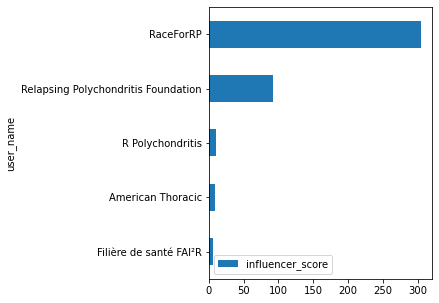

In [832]:
vx = users_with_retweets[["user_name", "influencer_score"]].sort_values(by="influencer_score", ascending=False).head(5)
vx[::-1].plot(x="user_name", y="influencer_score", kind="barh", figsize=(4, 5))


In [788]:
eigenvector_centrality_G = nx.algorithms.centrality.eigenvector_centrality(G, max_iter=1000)
users_with_retweets["eigenvector_centrality"] = pd.Series(eigenvector_centrality_G)
users_with_retweets[["user_name", "user_type", "eigenvector_centrality"]].sort_values(by="eigenvector_centrality", ascending=False).head(5)


,user_name,user_type,eigenvector_centrality
user_id,,,
978265108563529728,RaceForRP,ORG,0.680802
1020689741908455428,Relapsing Polychondritis Foundation,ORG,0.211297
297987127,R Polychondritis,ORG,0.145271
169679081,Sjögrens Forum,ORG,0.077739
958099306568921088,Relapsing Polychondritis UK,ORG,0.070510


In [820]:
# https://stackoverflow.com/questions/46008727/how-to-store-a-networkx-graph-for-visualizing-in-gephi
nx.write_gexf(G, "user_network.gexf")